In [3]:
##### Carga de librerías y carga del dataset 'df_model_xgb_rf.csv' y eliminación de filas con valores faltantes

# Carga de librerías
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Carga de datos
df_model_xgb = pd.read_csv(r"../data/final/1_panel/3_modelling/df_model_post_tratamiento_estadistico.csv")
df_model_xgb = df_model_xgb.dropna()
df_model_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24232 entries, 0 to 24231
Columns: 136 entries, status_inf to ratiodep
dtypes: bool(127), float64(4), int64(5)
memory usage: 4.6 MB


In [4]:
df_model_xgb

,status_inf,sexo_2,estadocivil_2,estadocivil_3,estadocivil_4,estadocivil_5,estadocivil_6,tuvotrabajo_2,categoria_trabajador_2,categoria_trabajador_3,...,onp_1,pagoespecie_1,horas_normtrabaja,edad,habitaciones,combustible,personas_ingresos,ingtrabw,alquiler,ratiodep
0,0,True,True,False,False,False,False,False,False,True,...,False,True,40,44,5.0,2.0,2,9.516132,400,0.400000
1,0,False,False,False,False,False,True,False,False,True,...,False,False,45,26,5.0,6.0,4,9.810330,150,0.800000
2,0,False,True,False,False,False,False,False,True,False,...,False,False,52,64,4.0,2.0,2,10.492052,500,0.500000
3,0,False,True,False,False,False,False,False,False,False,...,False,False,54,72,10.0,2.0,1,10.185277,0,0.500000
4,0,False,False,False,False,False,True,False,False,True,...,False,False,44,26,6.0,2.0,2,9.402035,100,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24227,1,False,True,False,False,False,False,False,True,False,...,False,False,60,61,6.0,2.0,4,10.087183,1000,0.571429
24228,0,False,True,False,False,False,False,False,False,False,...,False,True,48,56,7.0,2.0,4,11.191391,1000,0.666667
24229,0,False,False,False,False,False,True,False,False,True,...,False,False,42,29,7.0,2.0,4,10.660994,1000,0.666667
24230,0,False,True,False,False,False,False,False,False,False,...,False,True,52,31,3.0,9.0,2,9.886189,18,0.333333


Fitting 4 folds for each of 72 candidates, totalling 288 fits
Mejores parámetros: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
=== Reporte de Clasificación con Validación Cruzada (umbral fijo = 0.18) ===
              precision    recall  f1-score   support

     Clase 0     0.8984    0.6790    0.7734     19953
     Clase 1     0.3002    0.6420    0.4091      4279

    accuracy                         0.6725     24232
   macro avg     0.5993    0.6605    0.5912     24232
weighted avg     0.7928    0.6725    0.7091     24232


AUC promedio en validación cruzada: 0.726 (0.009)
Accuracy promedio en validación cruzada: 0.672 (0.005)
Precision promedio para la clase 1 en validación cruzada: 0.300 (0.006)
Precision promedio macro en validación cruzada: 0.599 (0.004)
Recall promedio para la clase 1 en validación cruzada: 0.642 (0.009)
Recall promedio macro en validación cruzada: 0.660 (0.007)
F1-score promedio 

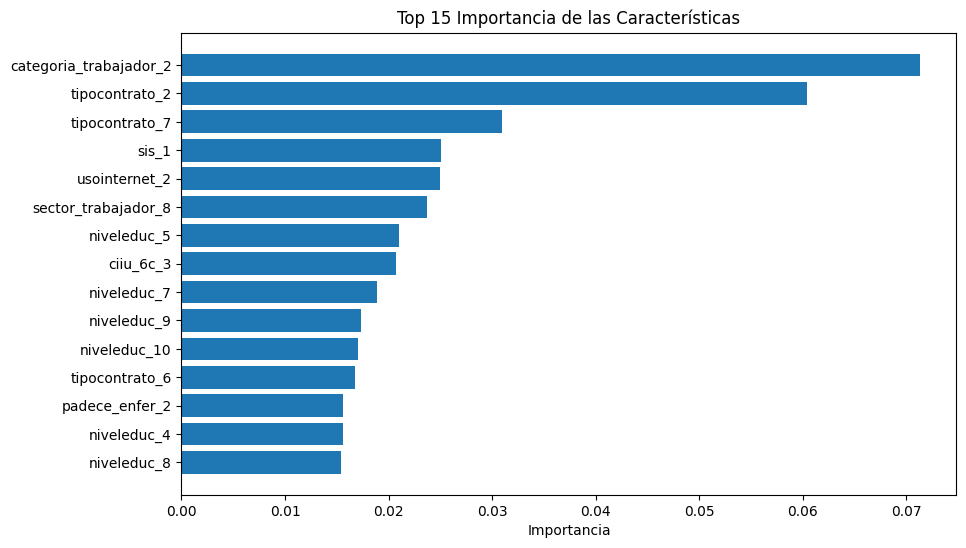

['../output/modelos/XGBoost_con_SMOTE_model_best.joblib']

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import numpy as np
import joblib  # Para guardar el modelo
import matplotlib.pyplot as plt

# 1. Definir dataset
X = df_model_xgb.drop(columns=['status_inf'])
y = df_model_xgb['status_inf']

# 2. Calcular el SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto')

# 3. Definir el modelo XGBoost (sin scale_pos_weight)
XGBoost_con_SMOTE_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
)

# 4. Crear pipeline con SMOTE y XGBoost
pipeline = Pipeline(steps=[('smote', smote), ('xgb', XGBoost_con_SMOTE_model)])

# 5. Definir los hiperparámetros para GridSearchCV (sin scale_pos_weight)
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__n_estimators': [100, 200],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

# 6. Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=4, scoring='roc_auc', n_jobs=1, verbose=1)

# 7. Entrenar el modelo con GridSearchCV
grid_search.fit(X, y)

# 8. Imprimir los mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")

# 9. Obtener el mejor modelo de la búsqueda en cuadrícula
best_model = grid_search.best_estimator_

# 10. Obtener las predicciones de probabilidad a través de la validación cruzada
y_proba_cv = cross_val_predict(best_model, X, y, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42), method='predict_proba')[:, 1]

# 11. Aplicar umbral fijo = 0.18
y_pred_adjusted_cv = (y_proba_cv >= 0.18).astype(int)

# 12. Reporte de clasificación con las predicciones ajustadas en la validación cruzada
print("=== Reporte de Clasificación con Validación Cruzada (umbral fijo = 0.18) ===")
print(classification_report(y, y_pred_adjusted_cv, target_names=["Clase 0", "Clase 1"], digits=4))

# 13. Calcular AUC, Recall (Clase 1), F1-score (Clase 1) para cada pliegue
auc_cv_scores = []
accuracy_cv_scores = []  # Guardamos la precisión de cada pliegue
precision_class_1_cv_scores = []  # Guardamos la precisión para la clase 1
precision_macro_cv_scores = []  # Guardamos la precisión macro (promedio)
recall_class_1_cv_scores = []  # Guardamos el recall para la clase 1
recall_macro_cv_scores = []  # Guardamos el recall macro (promedio)
f1_class_1_cv_scores = []  # F1-Score para clase 1
f1_macro_cv_scores = []  # F1-Score macro
f1_cv_scores = []

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Entrenar el modelo en el pliegue de entrenamiento
    best_model.fit(X_train, y_train)
    
    # Obtener las probabilidades predichas para AUC
    y_proba_test = best_model.predict_proba(X_test)[:, 1]
    
    # Calcular AUC para este pliegue
    auc_cv_scores.append(roc_auc_score(y_test, y_proba_test))
    
    # Obtener las predicciones para métricas de clasificación
    y_pred_test = (y_proba_test > 0.18).astype(int)
    
    # Calcular Precision para la clase 1
    precision_class_1 = precision_score(y_test, y_pred_test, pos_label=1)
    precision_class_1_cv_scores.append(precision_class_1)
    
    # Calcular Precision macro (promedio)
    precision_macro = precision_score(y_test, y_pred_test, average='macro')
    precision_macro_cv_scores.append(precision_macro)
    
    # Calcular Recall para la clase 1
    recall_class_1 = recall_score(y_test, y_pred_test, pos_label=1)
    recall_class_1_cv_scores.append(recall_class_1)
    
    # Calcular Recall macro (promedio)
    recall_macro = recall_score(y_test, y_pred_test, average='macro')
    recall_macro_cv_scores.append(recall_macro)
    
    # Calcular F1-Score para clase 1
    f1_class_1 = f1_score(y_test, y_pred_test, pos_label=1)
    f1_class_1_cv_scores.append(f1_class_1)
    
    # Calcular F1-Score macro (promedio)
    f1_macro = f1_score(y_test, y_pred_test, average='macro')
    f1_macro_cv_scores.append(f1_macro)
    
    # Calcular F1-Score general
    f1_cv_scores.append(f1_score(y_test, y_pred_test))
    
    # Calcular Accuracy general
    accuracy_cv_scores.append(accuracy_score(y_test, y_pred_test))

# 14. Calcular AUC promedio, Accuracy promedio, Precision, Recall, y F1-score
mean_auc = np.mean(auc_cv_scores)
std_auc = np.std(auc_cv_scores)

mean_accuracy = np.mean(accuracy_cv_scores)
std_accuracy = np.std(accuracy_cv_scores)

mean_precision_class_1 = np.mean(precision_class_1_cv_scores)
std_precision_class_1 = np.std(precision_class_1_cv_scores)

mean_precision_macro = np.mean(precision_macro_cv_scores)
std_precision_macro = np.std(precision_macro_cv_scores)

mean_recall_class_1 = np.mean(recall_class_1_cv_scores)
std_recall_class_1 = np.std(recall_class_1_cv_scores)

mean_recall_macro = np.mean(recall_macro_cv_scores)
std_recall_macro = np.std(recall_macro_cv_scores)

mean_f1_class_1 = np.mean(f1_class_1_cv_scores)
std_f1_class_1 = np.std(f1_class_1_cv_scores)

mean_f1_macro = np.mean(f1_macro_cv_scores)
std_f1_macro = np.std(f1_macro_cv_scores)

mean_f1 = np.mean(f1_cv_scores)
std_f1 = np.std(f1_cv_scores)

# 15. Imprimir resultados
print(f"\nAUC promedio en validación cruzada: {mean_auc:.3f} ({std_auc:.3f})")
print(f"Accuracy promedio en validación cruzada: {mean_accuracy:.3f} ({std_accuracy:.3f})")
print(f"Precision promedio para la clase 1 en validación cruzada: {mean_precision_class_1:.3f} ({std_precision_class_1:.3f})")
print(f"Precision promedio macro en validación cruzada: {mean_precision_macro:.3f} ({std_precision_macro:.3f})")
print(f"Recall promedio para la clase 1 en validación cruzada: {mean_recall_class_1:.3f} ({std_recall_class_1:.3f})")
print(f"Recall promedio macro en validación cruzada: {mean_recall_macro:.3f} ({std_recall_macro:.3f})")
print(f"F1-score promedio para la clase 1 en validación cruzada: {mean_f1_class_1:.3f} ({std_f1_class_1:.3f})")
print(f"F1-score promedio macro en validación cruzada: {mean_f1_macro:.3f} ({std_f1_macro:.3f})")
print(f"F1-score promedio en validación cruzada: {mean_f1:.3f} ({std_f1:.3f})")

# 16. Graficar la importancia de las características (Top 15)
importances = best_model.named_steps['xgb'].feature_importances_
indices = np.argsort(importances)[::-1]  # Ordenar las características por importancia

# Top 15 características más importantes
top_15_indices = indices[:15]
top_15_importances = importances[top_15_indices]
top_15_features = [X.columns[i] for i in top_15_indices]

# Graficar las importancias de las Top 15 características
plt.figure(figsize=(10, 6))
plt.title("Top 15 Importancia de las Características")
plt.barh(top_15_features, top_15_importances, align="center")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()  # Para que la barra más importante esté arriba
plt.show()

# 17. Guardar el mejor modelo entrenado
joblib.dump(best_model, '../output/modelos/XGBoost_con_SMOTE_model_best.joblib')


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
import numpy as np
import joblib  # Para guardar el modelo

# 1. Definir dataset
X = df_model_xgb.drop(columns=['status_inf'])
y = df_model_xgb['status_inf']

# 2. Definir el modelo XGBoost (sin rebalanceo)
XGBoost_sin_rebalanceo_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
)

# 3. Validación cruzada con 4 pliegues
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# 4. Obtener las predicciones de probabilidad a través de la validación cruzada
y_proba_cv = cross_val_predict(XGBoost_sin_rebalanceo_model, X, y, cv=cv, method='predict_proba')

# 5. Aplicar umbral fijo = 0.18
y_pred_adjusted_cv = (y_proba_cv[:, 1] > 0.18).astype(int)

# 6. Reporte de clasificación y métricas generales
print("=== Reporte de Clasificación con Validación Cruzada (umbral fijo = 0.18) ===")
print(classification_report(y, y_pred_adjusted_cv, target_names=["Clase 0", "Clase 1"], digits=4))

# 7. Calcular AUC, Recall (Clase 1), F1-score (Clase 1) para cada pliegue
auc_cv_scores = []
accuracy_cv_scores = []  # Guardamos la precisión de cada pliegue
precision_class_1_cv_scores = []  # Guardamos la precisión para la clase 1
precision_macro_cv_scores = []  # Guardamos la precisión macro (promedio)
recall_class_1_cv_scores = []  # Guardamos el recall para la clase 1
recall_macro_cv_scores = []  # Guardamos el recall macro (promedio)
f1_class_1_cv_scores = []  # F1-Score para clase 1
f1_macro_cv_scores = []  # F1-Score macro
f1_cv_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Entrenar el modelo en el pliegue de entrenamiento
    XGBoost_sin_rebalanceo_model.fit(X_train, y_train)
    
    # Obtener las probabilidades predichas para AUC
    y_proba_test = XGBoost_sin_rebalanceo_model.predict_proba(X_test)[:, 1]
    
    # Calcular AUC para este pliegue
    auc_cv_scores.append(roc_auc_score(y_test, y_proba_test))
    
    # Obtener las predicciones para métricas de clasificación
    y_pred_test = (y_proba_test > 0.18).astype(int)
    
    # Calcular Precision para la clase 1
    precision_class_1 = precision_score(y_test, y_pred_test, pos_label=1)
    precision_class_1_cv_scores.append(precision_class_1)
    
    # Calcular Precision macro (promedio)
    precision_macro = precision_score(y_test, y_pred_test, average='macro')
    precision_macro_cv_scores.append(precision_macro)
    
    # Calcular Recall para la clase 1
    recall_class_1 = recall_score(y_test, y_pred_test, pos_label=1)
    recall_class_1_cv_scores.append(recall_class_1)
    
    # Calcular Recall macro (promedio)
    recall_macro = recall_score(y_test, y_pred_test, average='macro')
    recall_macro_cv_scores.append(recall_macro)
    
    # Calcular F1-Score para clase 1
    f1_class_1 = f1_score(y_test, y_pred_test, pos_label=1)
    f1_class_1_cv_scores.append(f1_class_1)
    
    # Calcular F1-Score macro (promedio)
    f1_macro = f1_score(y_test, y_pred_test, average='macro')
    f1_macro_cv_scores.append(f1_macro)
    
    # Calcular F1-Score general
    f1_cv_scores.append(f1_score(y_test, y_pred_test))
    
    # Calcular Accuracy general
    accuracy_cv_scores.append(accuracy_score(y_test, y_pred_test))

# 8. Calcular AUC promedio, Accuracy promedio, Precision, Recall, y F1-score
mean_auc = np.mean(auc_cv_scores)
std_auc = np.std(auc_cv_scores)

mean_accuracy = np.mean(accuracy_cv_scores)
std_accuracy = np.std(accuracy_cv_scores)

mean_precision_class_1 = np.mean(precision_class_1_cv_scores)
std_precision_class_1 = np.std(precision_class_1_cv_scores)

mean_precision_macro = np.mean(precision_macro_cv_scores)
std_precision_macro = np.std(precision_macro_cv_scores)

mean_recall_class_1 = np.mean(recall_class_1_cv_scores)
std_recall_class_1 = np.std(recall_class_1_cv_scores)

mean_recall_macro = np.mean(recall_macro_cv_scores)
std_recall_macro = np.std(recall_macro_cv_scores)

mean_f1_class_1 = np.mean(f1_class_1_cv_scores)
std_f1_class_1 = np.std(f1_class_1_cv_scores)

mean_f1_macro = np.mean(f1_macro_cv_scores)
std_f1_macro = np.std(f1_macro_cv_scores)

mean_f1 = np.mean(f1_cv_scores)
std_f1 = np.std(f1_cv_scores)

# 9. Imprimir resultados
print(f"\nAUC promedio en validación cruzada: {mean_auc:.3f} ({std_auc:.3f})")
print(f"Accuracy promedio en validación cruzada: {mean_accuracy:.3f} ({std_accuracy:.3f})")
print(f"Precision promedio para la clase 1 en validación cruzada: {mean_precision_class_1:.3f} ({std_precision_class_1:.3f})")
print(f"Precision promedio macro en validación cruzada: {mean_precision_macro:.3f} ({std_precision_macro:.3f})")
print(f"Recall promedio para la clase 1 en validación cruzada: {mean_recall_class_1:.3f} ({std_recall_class_1:.3f})")
print(f"Recall promedio macro en validación cruzada: {mean_recall_macro:.3f} ({std_recall_macro:.3f})")
print(f"F1-score promedio para la clase 1 en validación cruzada: {mean_f1_class_1:.3f} ({std_f1_class_1:.3f})")
print(f"F1-score promedio macro en validación cruzada: {mean_f1_macro:.3f} ({std_f1_macro:.3f})")
print(f"F1-score promedio en validación cruzada: {mean_f1:.3f} ({std_f1:.3f})")

# 10. Guardar el modelo entrenado
joblib.dump(XGBoost_sin_rebalanceo_model, '../output/modelos/XGBoost_sin_rebalanceo_model.joblib')


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
import numpy as np
import joblib  # Para guardar el modelo

# 1. Definir dataset
X = df_model_xgb.drop(columns=['status_inf'])
y = df_model_xgb['status_inf']

# 2. Definir el modelo XGBoost (sin rebalanceo)
XGBoost_sin_rebalanceo_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
)

# 3. Validación cruzada con 4 pliegues
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# 4. Obtener las predicciones de probabilidad a través de la validación cruzada
y_proba_cv = cross_val_predict(XGBoost_sin_rebalanceo_model, X, y, cv=cv, method='predict_proba')

# 5. Aplicar umbral fijo = 0.18
y_pred_adjusted_cv = (y_proba_cv[:, 1] > 0.18).astype(int)

# 6. Reporte de clasificación y métricas generales
print("=== Reporte de Clasificación con Validación Cruzada (umbral fijo = 0.18) ===")
print(classification_report(y, y_pred_adjusted_cv, target_names=["Clase 0", "Clase 1"], digits=4))

# 7. Calcular AUC, Recall (Clase 1), F1-score (Clase 1) para cada pliegue
auc_cv_scores = []
accuracy_cv_scores = []  # Guardamos la precisión de cada pliegue
precision_class_1_cv_scores = []  # Guardamos la precisión para la clase 1
precision_macro_cv_scores = []  # Guardamos la precisión macro (promedio)
recall_class_1_cv_scores = []  # Guardamos el recall para la clase 1
recall_macro_cv_scores = []  # Guardamos el recall macro (promedio)
f1_class_1_cv_scores = []  # F1-Score para clase 1
f1_macro_cv_scores = []  # F1-Score macro
f1_cv_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Entrenar el modelo en el pliegue de entrenamiento
    XGBoost_sin_rebalanceo_model.fit(X_train, y_train)
    
    # Obtener las probabilidades predichas para AUC
    y_proba_test = XGBoost_sin_rebalanceo_model.predict_proba(X_test)[:, 1]
    
    # Calcular AUC para este pliegue
    auc_cv_scores.append(roc_auc_score(y_test, y_proba_test))
    
    # Obtener las predicciones para métricas de clasificación
    y_pred_test = (y_proba_test > 0.18).astype(int)
    
    # Calcular Precision para la clase 1
    precision_class_1 = precision_score(y_test, y_pred_test, pos_label=1)
    precision_class_1_cv_scores.append(precision_class_1)
    
    # Calcular Precision macro (promedio)
    precision_macro = precision_score(y_test, y_pred_test, average='macro')
    precision_macro_cv_scores.append(precision_macro)
    
    # Calcular Recall para la clase 1
    recall_class_1 = recall_score(y_test, y_pred_test, pos_label=1)
    recall_class_1_cv_scores.append(recall_class_1)
    
    # Calcular Recall macro (promedio)
    recall_macro = recall_score(y_test, y_pred_test, average='macro')
    recall_macro_cv_scores.append(recall_macro)
    
    # Calcular F1-Score para clase 1
    f1_class_1 = f1_score(y_test, y_pred_test, pos_label=1)
    f1_class_1_cv_scores.append(f1_class_1)
    
    # Calcular F1-Score macro (promedio)
    f1_macro = f1_score(y_test, y_pred_test, average='macro')
    f1_macro_cv_scores.append(f1_macro)
    
    # Calcular F1-Score general
    f1_cv_scores.append(f1_score(y_test, y_pred_test))
    
    # Calcular Accuracy general
    accuracy_cv_scores.append(accuracy_score(y_test, y_pred_test))

# 8. Calcular AUC promedio, Accuracy promedio, Precision, Recall, y F1-score
mean_auc = np.mean(auc_cv_scores)
std_auc = np.std(auc_cv_scores)

mean_accuracy = np.mean(accuracy_cv_scores)
std_accuracy = np.std(accuracy_cv_scores)

mean_precision_class_1 = np.mean(precision_class_1_cv_scores)
std_precision_class_1 = np.std(precision_class_1_cv_scores)

mean_precision_macro = np.mean(precision_macro_cv_scores)
std_precision_macro = np.std(precision_macro_cv_scores)

mean_recall_class_1 = np.mean(recall_class_1_cv_scores)
std_recall_class_1 = np.std(recall_class_1_cv_scores)

mean_recall_macro = np.mean(recall_macro_cv_scores)
std_recall_macro = np.std(recall_macro_cv_scores)

mean_f1_class_1 = np.mean(f1_class_1_cv_scores)
std_f1_class_1 = np.std(f1_class_1_cv_scores)

mean_f1_macro = np.mean(f1_macro_cv_scores)
std_f1_macro = np.std(f1_macro_cv_scores)

mean_f1 = np.mean(f1_cv_scores)
std_f1 = np.std(f1_cv_scores)

# 9. Imprimir resultados
print(f"\nAUC promedio en validación cruzada: {mean_auc:.3f} ({std_auc:.3f})")
print(f"Accuracy promedio en validación cruzada: {mean_accuracy:.3f} ({std_accuracy:.3f})")
print(f"Precision promedio para la clase 1 en validación cruzada: {mean_precision_class_1:.3f} ({std_precision_class_1:.3f})")
print(f"Precision promedio macro en validación cruzada: {mean_precision_macro:.3f} ({std_precision_macro:.3f})")
print(f"Recall promedio para la clase 1 en validación cruzada: {mean_recall_class_1:.3f} ({std_recall_class_1:.3f})")
print(f"Recall promedio macro en validación cruzada: {mean_recall_macro:.3f} ({std_recall_macro:.3f})")
print(f"F1-score promedio para la clase 1 en validación cruzada: {mean_f1_class_1:.3f} ({std_f1_class_1:.3f})")
print(f"F1-score promedio macro en validación cruzada: {mean_f1_macro:.3f} ({std_f1_macro:.3f})")
print(f"F1-score promedio en validación cruzada: {mean_f1:.3f} ({std_f1:.3f})")

# 10. Imprimir las importancias de las características
importances = XGBoost_sin_rebalanceo_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nImportancias de las características:")
for i in range(len(importances)):
    print(f"{X.columns[indices[i]]}: {importances[indices[i]]:.4f}")

# 11. Guardar el modelo entrenado
joblib.dump(XGBoost_sin_rebalanceo_model, '../output/modelos/XGBoost_sin_rebalanceo_model.joblib')


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import numpy as np
import joblib  # Para guardar el modelo

# 1. Definir dataset
X = df_model_xgb.drop(columns=['status_inf'])
y = df_model_xgb['status_inf']

# 2. Calcular el SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto')

# 3. Definir el modelo XGBoost (sin scale_pos_weight)
XGBoost_con_SMOTE_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
)

# 4. Crear pipeline con SMOTE y XGBoost
pipeline = Pipeline(steps=[('smote', smote), ('xgb', XGBoost_con_SMOTE_model)])

# 5. Definir los hiperparámetros para GridSearchCV (sin scale_pos_weight)
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__n_estimators': [100, 200],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

# 6. Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=4, scoring='roc_auc', n_jobs=1, verbose=1)

# 7. Entrenar el modelo con GridSearchCV
grid_search.fit(X, y)

# 8. Imprimir los mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")

# 9. Obtener el mejor modelo de la búsqueda en cuadrícula
best_model = grid_search.best_estimator_

# 10. Obtener las predicciones de probabilidad a través de la validación cruzada
y_proba_cv = cross_val_predict(best_model, X, y, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42), method='predict_proba')[:, 1]

# 11. Aplicar umbral fijo = 0.18
y_pred_adjusted_cv = (y_proba_cv >= 0.18).astype(int)

# 12. Reporte de clasificación con las predicciones ajustadas en la validación cruzada
print("=== Reporte de Clasificación con Validación Cruzada (umbral fijo = 0.18) ===")
print(classification_report(y, y_pred_adjusted_cv, target_names=["Clase 0", "Clase 1"], digits=4))

# 13. Calcular AUC, Recall (Clase 1), F1-score (Clase 1) para cada pliegue
auc_cv_scores = []
recall_class_1_cv_scores = []
f1_class_1_cv_scores = []

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Entrenar el modelo en el pliegue de entrenamiento
    best_model.fit(X_train, y_train)
    
    # Obtener las probabilidades predichas para AUC
    y_proba_test = best_model.predict_proba(X_test)[:, 1]
    
    # Calcular AUC para este pliegue
    auc_cv_scores.append(roc_auc_score(y_test, y_proba_test))
    
    # Obtener las predicciones para métricas de clasificación
    y_pred_test = (y_proba_test > 0.18).astype(int)
    
    # Calcular Recall y F1-score para la clase 1
    recall_class_1_cv_scores.append(recall_score(y_test, y_pred_test))
    f1_class_1_cv_scores.append(f1_score(y_test, y_pred_test))

# 14. Calcular AUC promedio, Recall de la clase 1 y F1-score de la clase 1, con sus desviaciones estándar
mean_auc = np.mean(auc_cv_scores)
std_auc = np.std(auc_cv_scores)

mean_recall_class_1 = np.mean(recall_class_1_cv_scores)
std_recall_class_1 = np.std(recall_class_1_cv_scores)

mean_f1_class_1 = np.mean(f1_class_1_cv_scores)
std_f1_class_1 = np.std(f1_class_1_cv_scores)

# 15. Imprimir resultados
print(f"\nAUC promedio en validación cruzada: {mean_auc:.3f} ({std_auc:.3f})")
print(f"Recall promedio para la clase 1: {mean_recall_class_1:.3f} ({std_recall_class_1:.3f})")
print(f"F1-score promedio para la clase 1: {mean_f1_class_1:.3f} ({std_f1_class_1:.3f})")
# 16. Guardar el mejor modelo entrenado
joblib.dump(best_model, '../output/modelos/XGBoost_con_SMOTE_model_best.joblib')


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import numpy as np
import joblib  # Para guardar el modelo
import matplotlib.pyplot as plt

# 1. Definir dataset
X = df_model_xgb.drop(columns=['status_inf'])
y = df_model_xgb['status_inf']

# 2. Calcular el SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto')

# 3. Definir el modelo XGBoost (sin scale_pos_weight)
XGBoost_con_SMOTE_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
)

# 4. Crear pipeline con SMOTE y XGBoost
pipeline = Pipeline(steps=[('smote', smote), ('xgb', XGBoost_con_SMOTE_model)])

# 5. Definir los hiperparámetros para GridSearchCV (sin scale_pos_weight)
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__n_estimators': [100, 200],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

# 6. Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=4, scoring='roc_auc', n_jobs=1, verbose=1)

# 7. Entrenar el modelo con GridSearchCV
grid_search.fit(X, y)

# 8. Imprimir los mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")

# 9. Obtener el mejor modelo de la búsqueda en cuadrícula
best_model = grid_search.best_estimator_

# 10. Obtener las predicciones de probabilidad a través de la validación cruzada
y_proba_cv = cross_val_predict(best_model, X, y, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42), method='predict_proba')[:, 1]

# 11. Aplicar umbral fijo = 0.18
y_pred_adjusted_cv = (y_proba_cv >= 0.18).astype(int)

# 12. Reporte de clasificación con las predicciones ajustadas en la validación cruzada
print("=== Reporte de Clasificación con Validación Cruzada (umbral fijo = 0.18) ===")
print(classification_report(y, y_pred_adjusted_cv, target_names=["Clase 0", "Clase 1"], digits=4))

# 13. Calcular AUC, Recall (Clase 1), F1-score (Clase 1) para cada pliegue
auc_cv_scores = []
accuracy_cv_scores = []  # Guardamos la precisión de cada pliegue
precision_class_1_cv_scores = []  # Guardamos la precisión para la clase 1
precision_macro_cv_scores = []  # Guardamos la precisión macro (promedio)
recall_class_1_cv_scores = []  # Guardamos el recall para la clase 1
recall_macro_cv_scores = []  # Guardamos el recall macro (promedio)
f1_class_1_cv_scores = []  # F1-Score para clase 1
f1_macro_cv_scores = []  # F1-Score macro
f1_cv_scores = []

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Entrenar el modelo en el pliegue de entrenamiento
    best_model.fit(X_train, y_train)
    
    # Obtener las probabilidades predichas para AUC
    y_proba_test = best_model.predict_proba(X_test)[:, 1]
    
    # Calcular AUC para este pliegue
    auc_cv_scores.append(roc_auc_score(y_test, y_proba_test))
    
    # Obtener las predicciones para métricas de clasificación
    y_pred_test = (y_proba_test > 0.18).astype(int)
    
    # Calcular Precision para la clase 1
    precision_class_1 = precision_score(y_test, y_pred_test, pos_label=1)
    precision_class_1_cv_scores.append(precision_class_1)
    
    # Calcular Precision macro (promedio)
    precision_macro = precision_score(y_test, y_pred_test, average='macro')
    precision_macro_cv_scores.append(precision_macro)
    
    # Calcular Recall para la clase 1
    recall_class_1 = recall_score(y_test, y_pred_test, pos_label=1)
    recall_class_1_cv_scores.append(recall_class_1)
    
    # Calcular Recall macro (promedio)
    recall_macro = recall_score(y_test, y_pred_test, average='macro')
    recall_macro_cv_scores.append(recall_macro)
    
    # Calcular F1-Score para clase 1
    f1_class_1 = f1_score(y_test, y_pred_test, pos_label=1)
    f1_class_1_cv_scores.append(f1_class_1)
    
    # Calcular F1-Score macro (promedio)
    f1_macro = f1_score(y_test, y_pred_test, average='macro')
    f1_macro_cv_scores.append(f1_macro)
    
    # Calcular F1-Score general
    f1_cv_scores.append(f1_score(y_test, y_pred_test))
    
    # Calcular Accuracy general
    accuracy_cv_scores.append(accuracy_score(y_test, y_pred_test))

# 14. Calcular AUC promedio, Accuracy promedio, Precision, Recall, y F1-score
mean_auc = np.mean(auc_cv_scores)
std_auc = np.std(auc_cv_scores)

mean_accuracy = np.mean(accuracy_cv_scores)
std_accuracy = np.std(accuracy_cv_scores)

mean_precision_class_1 = np.mean(precision_class_1_cv_scores)
std_precision_class_1 = np.std(precision_class_1_cv_scores)

mean_precision_macro = np.mean(precision_macro_cv_scores)
std_precision_macro = np.std(precision_macro_cv_scores)

mean_recall_class_1 = np.mean(recall_class_1_cv_scores)
std_recall_class_1 = np.std(recall_class_1_cv_scores)

mean_recall_macro = np.mean(recall_macro_cv_scores)
std_recall_macro = np.std(recall_macro_cv_scores)

mean_f1_class_1 = np.mean(f1_class_1_cv_scores)
std_f1_class_1 = np.std(f1_class_1_cv_scores)

mean_f1_macro = np.mean(f1_macro_cv_scores)
std_f1_macro = np.std(f1_macro_cv_scores)

mean_f1 = np.mean(f1_cv_scores)
std_f1 = np.std(f1_cv_scores)

# 15. Imprimir resultados
print(f"\nAUC promedio en validación cruzada: {mean_auc:.3f} ({std_auc:.3f})")
print(f"Accuracy promedio en validación cruzada: {mean_accuracy:.3f} ({std_accuracy:.3f})")
print(f"Precision promedio para la clase 1 en validación cruzada: {mean_precision_class_1:.3f} ({std_precision_class_1:.3f})")
print(f"Precision promedio macro en validación cruzada: {mean_precision_macro:.3f} ({std_precision_macro:.3f})")
print(f"Recall promedio para la clase 1 en validación cruzada: {mean_recall_class_1:.3f} ({std_recall_class_1:.3f})")
print(f"Recall promedio macro en validación cruzada: {mean_recall_macro:.3f} ({std_recall_macro:.3f})")
print(f"F1-score promedio para la clase 1 en validación cruzada: {mean_f1_class_1:.3f} ({std_f1_class_1:.3f})")
print(f"F1-score promedio macro en validación cruzada: {mean_f1_macro:.3f} ({std_f1_macro:.3f})")
print(f"F1-score promedio en validación cruzada: {mean_f1:.3f} ({std_f1:.3f})")

# 16. Graficar la importancia de las características (Top 15)
importances = best_model.named_steps['xgb'].feature_importances_
indices = np.argsort(importances)[::-1]  # Ordenar las características por importancia

# Top 15 características más importantes
top_15_indices = indices[:15]
top_15_importances = importances[top_15_indices]
top_15_features = [X.columns[i] for i in top_15_indices]

# Graficar las importancias de las Top 15 características
plt.figure(figsize=(10, 6))
plt.title("Top 15 Importancia de las Características")
plt.barh(top_15_features, top_15_importances, align="center")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()  # Para que la barra más importante esté arriba
plt.show()

# 17. Guardar el mejor modelo entrenado
joblib.dump(best_model, '../output/modelos/XGBoost_con_SMOTE_model_best.joblib')


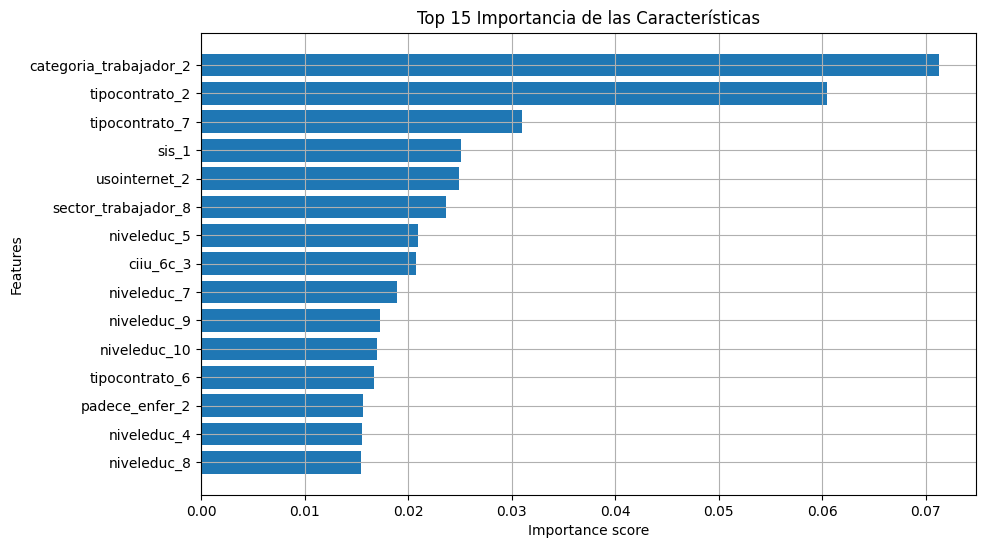

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Asegúrate de que todas las características (no solo las numéricas) se usen
X_all = X  # Usamos todas las columnas originales sin filtrarlas por tipo

# 2. Calcular las importancias de las características del modelo XGBoost
importances = best_model.named_steps['xgb'].feature_importances_

# 3. Ordenar las características por su importancia
indices = np.argsort(importances)[::-1]  # Ordenar las características por importancia

# 4. Seleccionar solo las 15 características más importantes
top_15_indices = indices[:15]
top_15_importances = importances[top_15_indices]
top_15_features = [X_all.columns[i] for i in top_15_indices]

# 5. Graficar las importancias de las Top 15 características
plt.figure(figsize=(10, 6))
plt.title("Top 15 Importancia de las Características")
plt.barh(top_15_features, top_15_importances, align="center")
plt.xlabel("Importance score")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Para que la barra más importante esté arriba
plt.grid(True)
plt.show()